# Finding the Best Recession Predictors with MDA

Time for the main event! We'll use Multiple Discriminant Analysis to figure out which economic indicators are the best at spotting recessions before they hit. Think of it as teaching our model to recognize the warning signs.

In [1]:
# Import notebook utilities
from notebook_utils import init_notebook, load_data, display_data_info, save_figure
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split

# Initialize notebook environment
init_notebook()

# Import from econ_downturn package
from econ_downturn import (
    apply_mda, create_discriminant_time_series,
    plot_feature_importance, plot_mda_projection, plot_discriminant_time_series
)

Initializing notebook environment...
✓ Added c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\src to Python path
✓ econ_downturn package imported successfully
✓ Notebook environment configured
✓ Environment variables loaded

Available data paths:
  fred_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred
  nber_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\nber
  processed_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed
  fred_all_indicators: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred\all_indicators.csv
  nber_recession_indicator: c:\Users\Admin\e

## Loading Our Engineered Features

First, we will load the datasets prepared during our feature engineering stage.

To refresh your memory, here is a description of these datasets:

1. Data with Features:

    This is our basic transformed data, including all original indicators with the engineered lagged and smoothed variables.


2. Normalized Data:

    As discussed earlier, putting each of our macroeconomic indicators on the same numeric scale is key for our PCA and MDA steps. This data is ready to be fed into our PCA step.


3. PCA Data:

    This saved file includes only the principal components identified from PCA, as well as the target recession indicator. This is the most compact and analysis-ready version of our data, and is optimized for training our MDA model.


These will become relevant as we get into model creation and testing.

In [2]:
# Get data paths for loading processed data
from econ_downturn import get_data_paths
data_paths = get_data_paths()
data_dir = data_paths['processed_dir']

# Load the dataset with features
features_path = os.path.join(data_dir, 'data_with_features.csv')
if os.path.exists(features_path):
    data_features = pd.read_csv(features_path, index_col=0, parse_dates=True)
    print(f"Loaded dataset with features, shape: {data_features.shape}")
else:
    print(f"Dataset with features not found at {features_path}")
    data_features = pd.DataFrame()

# Load the normalized dataset
normalized_path = os.path.join(data_dir, 'data_normalized.csv')
if os.path.exists(normalized_path):
    data_normalized = pd.read_csv(normalized_path, index_col=0, parse_dates=True)
    print(f"Loaded normalized dataset, shape: {data_normalized.shape}")
else:
    print(f"Normalized dataset not found at {normalized_path}")
    data_normalized = pd.DataFrame()

# Load the PCA dataset
pca_path = os.path.join(data_dir, 'data_pca.csv')
if os.path.exists(pca_path):
    data_pca = pd.read_csv(pca_path, index_col=0, parse_dates=True)
    print(f"Loaded PCA dataset, shape: {data_pca.shape}")
else:
    print(f"PCA dataset not found at {pca_path}")
    data_pca = pd.DataFrame()

Loaded dataset with features, shape: (635, 97)
Loaded normalized dataset, shape: (635, 97)
Loaded PCA dataset, shape: (635, 27)


## Setting Up for Analysis

Before we start the model training, we need to implement the best practice of splitting data into training and testing subsets. The model should generalize the unseen data well to indicate success.

We use a 70/30 split (70% for training, 30% for testing).

First let's break down the prepare_data_for_mda() function that we established in our utility package. There are three base transformations and two outputs.

#### Base Transformations:

1. Validating inputs:
    This tranformation checks whether the dataframe inputed in the function is empty or missing the recession flagging column. If so, the process is exited.

2. Seperating the features and target indicator:
    As with our previous work, we always need to seperate our features from our recession indicator. If our recession indicator was used as a feature, we would be using the target outcome within our MDA model. This would be redundant. Independent variables (our features) are extracted as X, while the dependent variable (the recession flag) is set to y.

3. Training split:
    As mentioned previously, we use a 70/30 training split. The test size is 30%, while the training size is 70%. This gives an optimal quantity of unseen data to test the final model on.

note: Stratification is applied using y. This is to ensure that both the training and the test splits receive an equal proportion of recessionary periods.


#### Function Outputs:

1. The splits: The first tuple contains data (X_train, X_test, y_train, y_test) for modeling.

2. The full data: (X, y) represents the full dataset (used later for projections and visualization).


This function's described setup will be repeated independently for each of the three datasets:

features: The original engineered variables.

normalized: Scaled version the original.

pca: Dimensionality-reduced version via PCA.

The valid results are stored in the datasets dictionary. These are keyed by the dataset name. This enables us to easily loop through the dictionary and apply MDA consistently in the next section of our code.

In [3]:
# Function to prepare data for MDA
def prepare_data_for_mda(data):
    if data.empty or 'recession' not in data.columns:
        print("Data is empty or does not contain the recession indicator.")
        return None, None
    
    # Separate features and target
    X = data.drop(columns=['recession'])
    y = data['recession']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    return (X_train, X_test, y_train, y_test), (X, y)

# Prepare the datasets for MDA
datasets = {}

if not data_features.empty and 'recession' in data_features.columns:
    datasets['features'] = prepare_data_for_mda(data_features)
    print("Prepared dataset with features for MDA")

if not data_normalized.empty and 'recession' in data_normalized.columns:
    datasets['normalized'] = prepare_data_for_mda(data_normalized)
    print("Prepared normalized dataset for MDA")

if not data_pca.empty and 'recession' in data_pca.columns:
    datasets['pca'] = prepare_data_for_mda(data_pca)
    print("Prepared PCA dataset for MDA")

Prepared dataset with features for MDA
Prepared normalized dataset for MDA


## Running the MDA Model

This step will fit a Multiple Discriminant Analysis model (or MDA) to each prepared dataset to effectively classify recession periods. This is the key to our project.

There are two core functions used to fit and evaluate the model:

#### 1. apply_mda_and_evaluate()
1a. This wrapper function handles the infastructure of the entire MDA pipeline for our dataset. It takes the train/test split and full dataset as inputs.

2a. The full dataset (X_full, y_full) are passed to be used later for visualization.

3a. The function returns four performance metrics after the model is fitted: accuracy, confusion matrix, classification report, and cross-validation scores.

4a. The function displays and plots the top 15 predictors.

#### 2. apply_mda()
This function handles the actual training of the Linear Discriminant model
This function, imported from the project’s modeling utilities, handles the actual training of the Linear Discriminant model.

1b. The model is fit to the training data, and starts to generate predictions.

2b. Also, it uses cross-validation on the training set to estimate generalizability.

3b. Once the validation is finished, the model is refit on the entire dataset to prepare for visualization steps.

4b. The final outputs will be a trained model, prediction scores, and a ranked list of importance of features.

2025-07-06 13:43:02,450 - econ_downturn.models.mda - INFO - Training set shape: (444, 96), Testing set shape: (191, 96)
2025-07-06 13:43:02,484 - econ_downturn.models.mda - INFO - Accuracy: 0.9581
2025-07-06 13:43:02,485 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[165   4]
 [  4  18]]
2025-07-06 13:43:02,486 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       169
         1.0       0.82      0.82      0.82        22

    accuracy                           0.96       191
   macro avg       0.90      0.90      0.90       191
weighted avg       0.96      0.96      0.96       191

2025-07-06 13:43:02,569 - econ_downturn.models.mda - INFO - Cross-Validation Scores: [0.96062992 0.96850394 0.96850394 0.93700787 0.99212598]
2025-07-06 13:43:02,570 - econ_downturn.models.mda - INFO - Mean CV Score: 0.9654
2025-07-06 13:43:02,576 - econ_downturn.models.mda - INFO - Top 5 Mo

,Feature,Importance
78,INDUSTRIAL_PROD_pct_change_1,919.959295
62,GDP_pct_change_12,482.467216
80,INDUSTRIAL_PROD_pct_change_12,476.874357
61,GDP_pct_change_3,371.100226
67,CPI_pct_change_3,353.996040
66,CPI_pct_change_1,334.891865
60,GDP_pct_change_1,138.832301
79,INDUSTRIAL_PROD_pct_change_3,130.831264
83,RETAIL_SALES_pct_change_12,70.299489
64,UNEMPLOYMENT_pct_change_3,67.531673


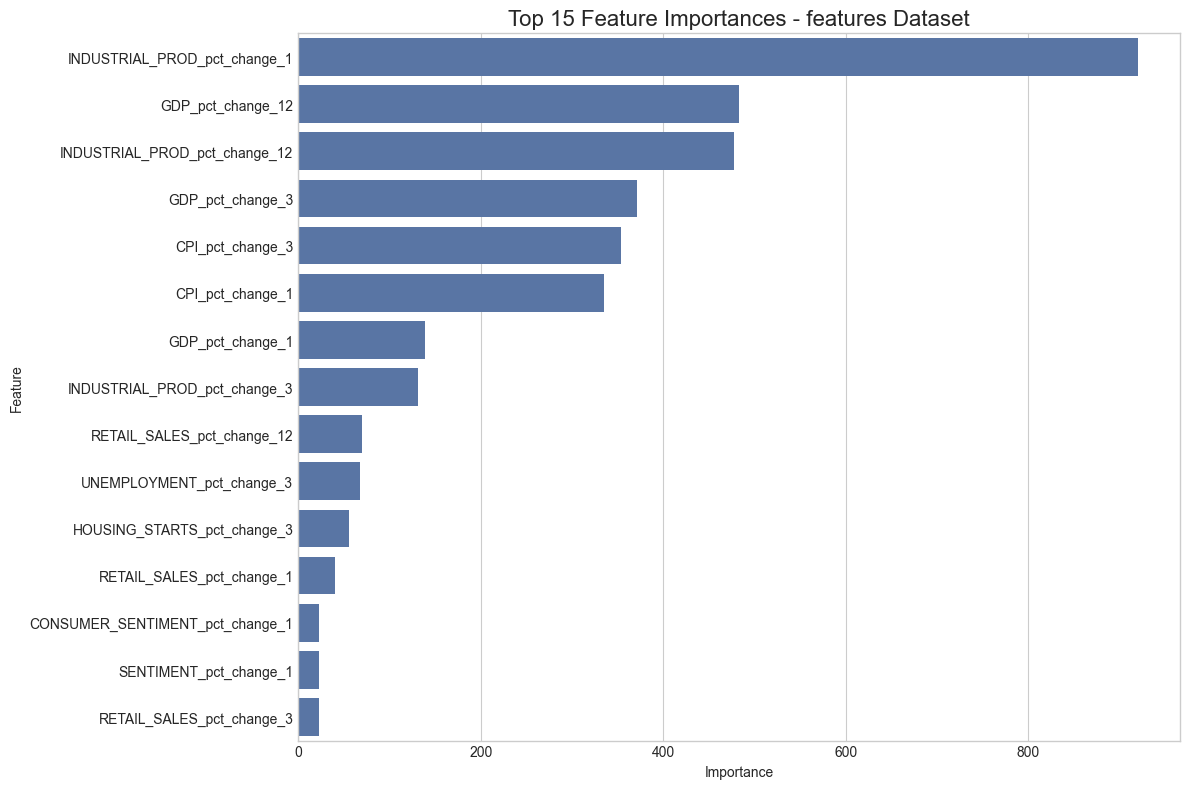

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\feature_importance_features.png
2025-07-06 13:43:03,034 - econ_downturn.models.mda - INFO - Training set shape: (444, 96), Testing set shape: (191, 96)
2025-07-06 13:43:03,054 - econ_downturn.models.mda - INFO - Accuracy: 0.9581
2025-07-06 13:43:03,055 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[165   4]
 [  4  18]]
2025-07-06 13:43:03,055 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       169
         1.0       0.82      0.82      0.82        22

    accuracy                           0.96       191
   macro avg       0.90      0.90      0.90       191
weighted avg       0.96      0.96      0.96       191

2025-07-06 13:43:03,116 - econ_downturn.models.mda - INFO - Cross-Validation Scores: [0.96062992 0.9685039

,Feature,Importance
2,CPI,309.869941
20,CPI_lag1,242.697649
13,GDP_lag3,240.778578
36,INDUSTRIAL_PROD_lag1,233.468411
15,GDP_lag12,174.914253
0,GDP,162.389544
39,INDUSTRIAL_PROD_lag12,147.470471
21,CPI_lag3,125.467432
12,GDP_lag1,91.357047
23,CPI_lag12,69.250808


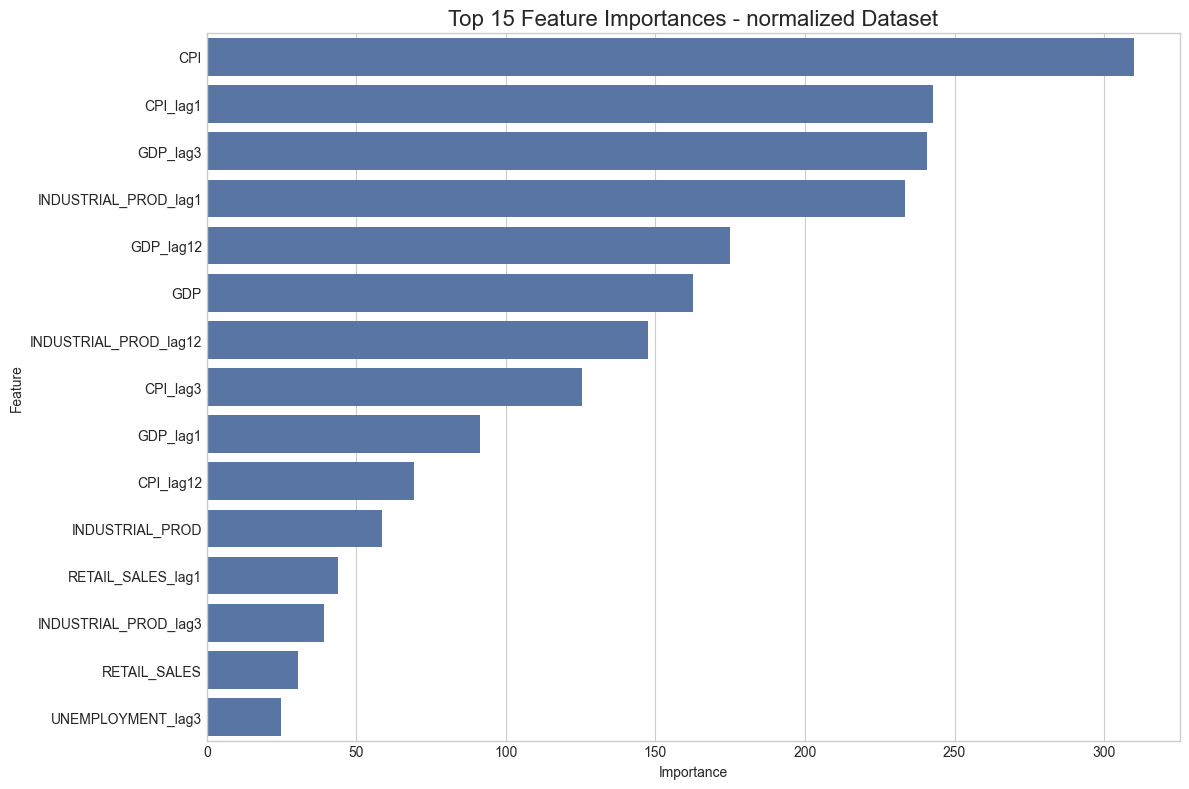

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\feature_importance_normalized.png


In [4]:
# Function to apply MDA and evaluate the model
def apply_mda_and_evaluate(dataset_name, split_data, full_data):
    if split_data is None or full_data is None:
        print(f"No data available for {dataset_name}")
        return None
    
    X_train, X_test, y_train, y_test = split_data
    X_full, y_full = full_data
    
    # Apply MDA using the package function (it handles train/test split internally)
    mda_results = apply_mda(X_full, y_full, test_size=0.3, random_state=42)
    
    print(f"\nResults for {dataset_name} dataset:")
    print(f"Accuracy: {mda_results['accuracy']:.4f}")
    print("\nConfusion Matrix:")
    print(mda_results['conf_matrix'])
    print("\nClassification Report:")
    print(mda_results['class_report'])
    print(f"\nCross-Validation Scores: {mda_results['cv_scores']}")
    print(f"Mean CV Score: {mda_results['cv_scores'].mean():.4f}")
    
    # Plot feature importances
    if mda_results['feature_importance'] is not None:
        print("\nTop 10 Most Important Features:")
        display(mda_results['feature_importance'].head(10))
        
        # Plot feature importances
        fig = plot_feature_importance(mda_results['feature_importance'], top_n=15)
        plt.title(f'Top 15 Feature Importances - {dataset_name} Dataset', fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Save the figure
        save_figure(fig, f"feature_importance_{dataset_name}.png")
    
    return mda_results

# Apply MDA to each dataset
mda_results = {}

for name, (split_data, full_data) in datasets.items():
    mda_results[name] = apply_mda_and_evaluate(name, split_data, full_data)

## Visualizing Our Results

Two key plots will check how well our MDA model distinguishes between recessionary vs. non-recessionary periods.

1. plot_mda_projection() shows a 2d projection of our model's decision space. This clearly shows how our model seperates the two binary classes. This gives a visual evaluation of the discriminative power of the model learned from training.

2. create_discriminant_time_series() creates a time series of the discriminant function values using the trained MDA model. This is then visualized using plot_discriminant_time_series(). The goal of this is to highlight when the economy exhibits similar signals to historically recognized reccessions.

Both plots are saved for future reference.

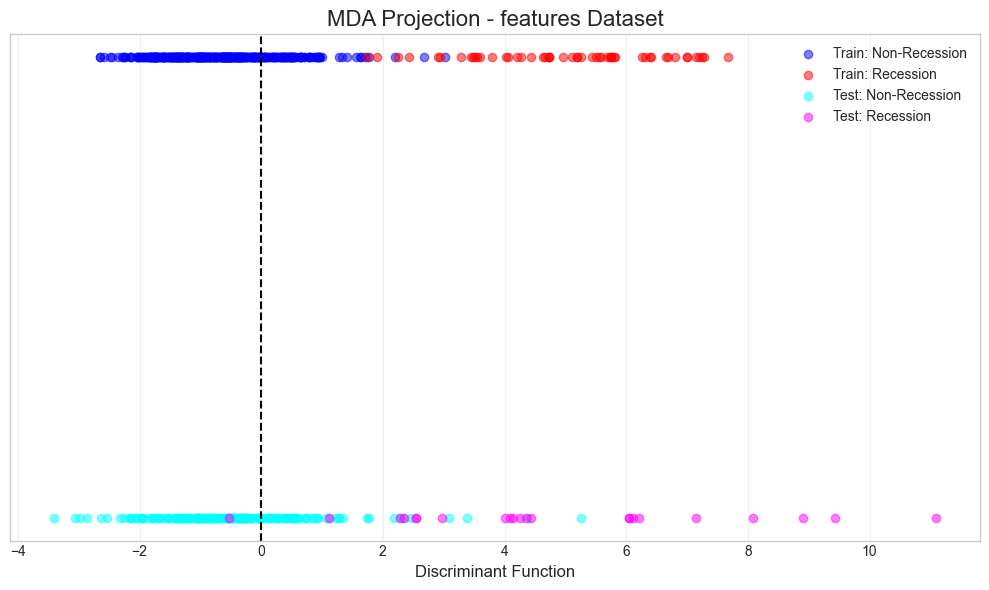

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\mda_projection_features.png


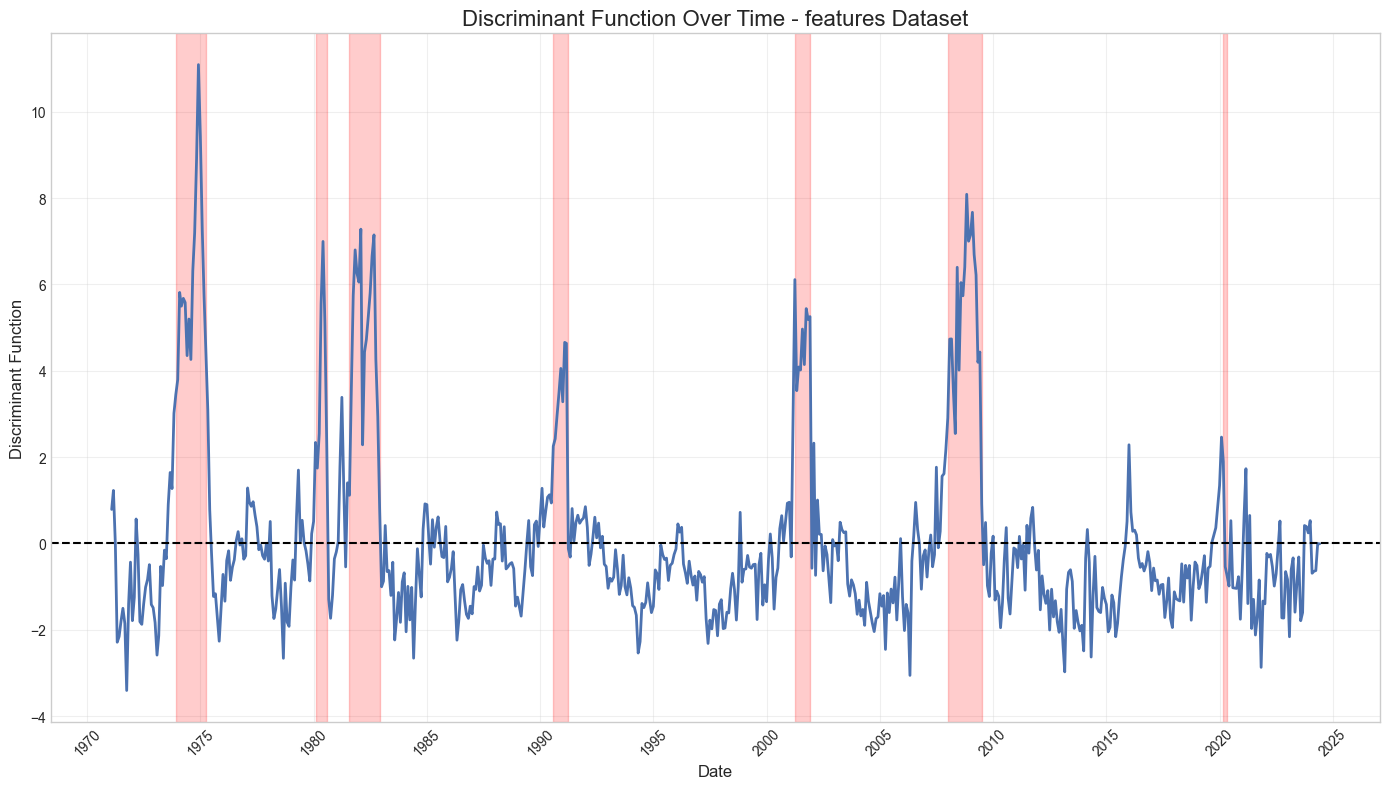

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\discriminant_time_series_features.png


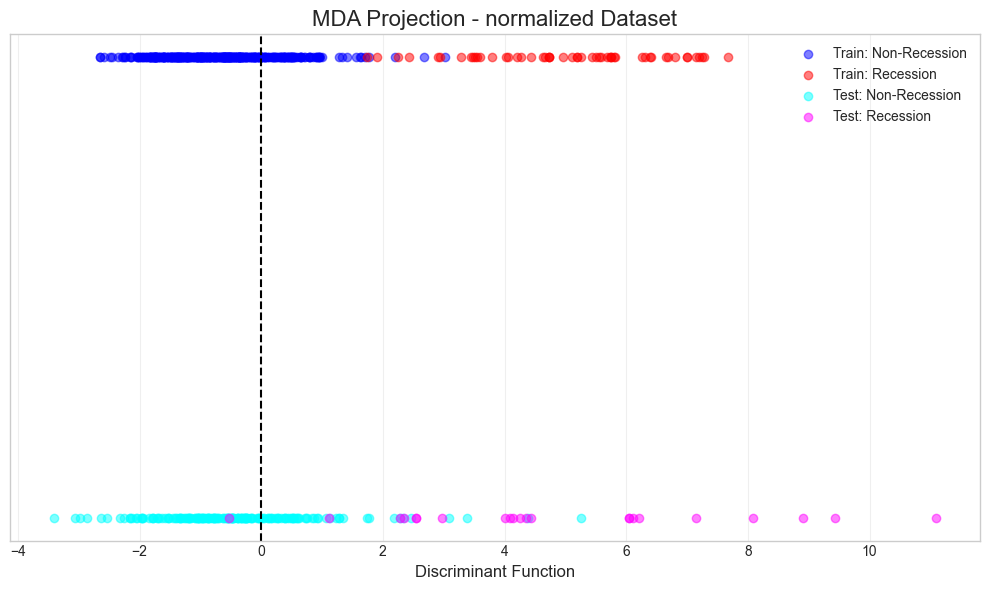

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\mda_projection_normalized.png


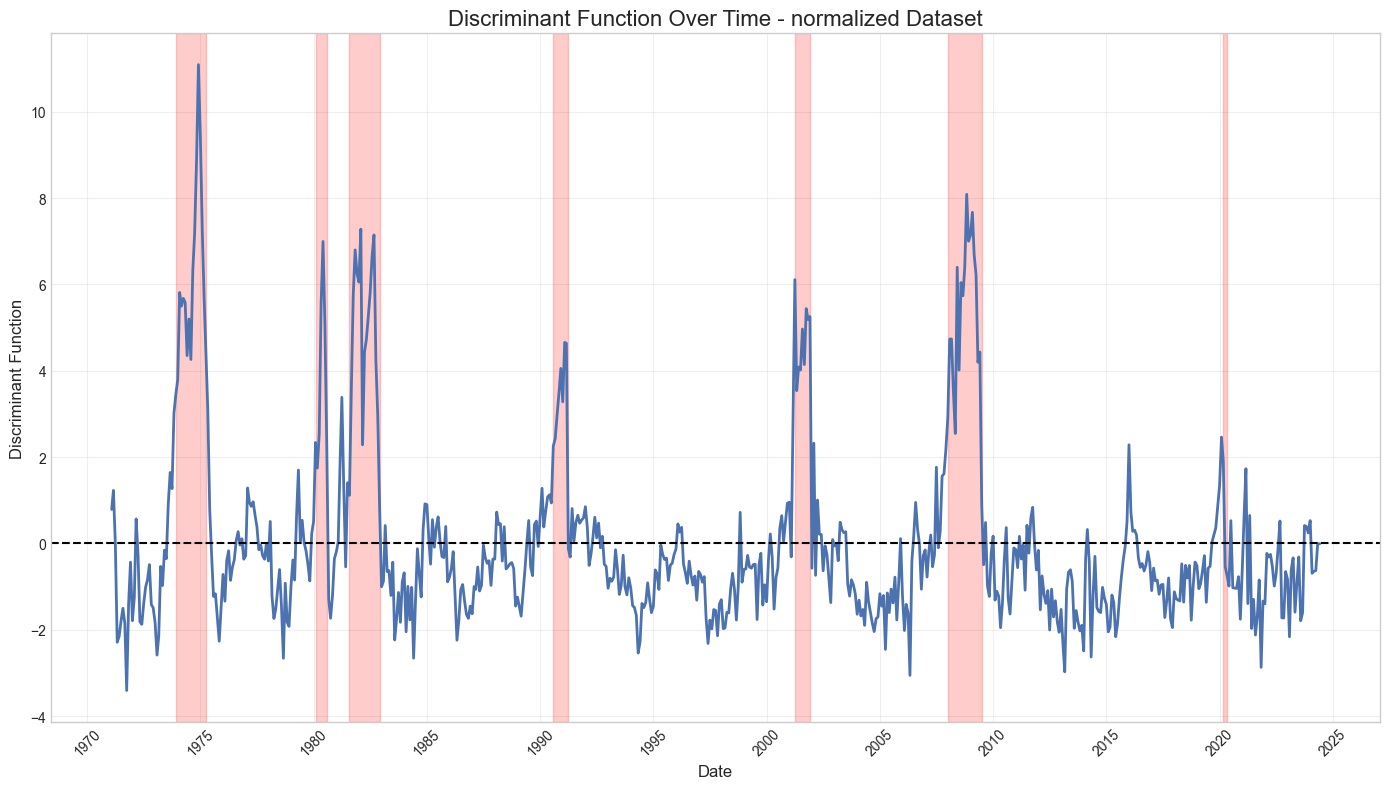

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\discriminant_time_series_normalized.png


In [5]:
# Function to visualize MDA results
def visualize_mda_results(dataset_name, mda_results, split_data, full_data):
    if mda_results is None or split_data is None or full_data is None:
        print(f"No data available for {dataset_name}")
        return
    
    X_train, X_test, y_train, y_test = split_data
    X_full, y_full = full_data
    
    # Plot MDA projection (function extracts data from mda_results internally)
    fig = plot_mda_projection(mda_results)
    plt.title(f'MDA Projection - {dataset_name} Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    save_figure(fig, f"mda_projection_{dataset_name}.png")
    
    # Create discriminant time series
    discriminant_df = create_discriminant_time_series(mda_results['model'], X_full, y_full)
    
    # Plot discriminant time series
    fig = plot_discriminant_time_series(discriminant_df)
    plt.title(f'Discriminant Function Over Time - {dataset_name} Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    save_figure(fig, f"discriminant_time_series_{dataset_name}.png")

# Visualize MDA results for each dataset
for name, results in mda_results.items():
    if results is not None:
        visualize_mda_results(name, results, datasets[name][0], datasets[name][1])

## Which Indicators Matter Most?

This step will contain model interpretation by examining the most influential features that were identified during MDA training.

1. The identify_key_predictors() function will extract top features ranked by their importance (which was stored in the feature_importance output from MDA).

2. It then will categorize these predictors into original indicators, lagged features, and rate-of-change metrics.

3. This helps us better understand which features congtribute most significantly to recession detenction.

In [6]:
# Function to identify key recession predictors
def identify_key_predictors(dataset_name, mda_results):
    if mda_results is None or mda_results['feature_importance'] is None:
        print(f"No feature importance available for {dataset_name}")
        return
    
    feature_importance = mda_results['feature_importance']
    
    print(f"\nKey Recession Predictors from {dataset_name} Dataset:")
    
    # Get the top 10 features
    top_features = feature_importance.head(10)
    display(top_features)
    
    # Categorize the features
    categories = {
        'Original': [],
        'Lag': [],
        'Rate of Change': []
    }
    
    for feature in top_features['Feature']:
        if '_lag' in feature:
            categories['Lag'].append(feature)
        elif '_pct_change' in feature or '_roc' in feature:
            categories['Rate of Change'].append(feature)
        else:
            categories['Original'].append(feature)
    
    print("\nFeatures by Category:")
    for category, features in categories.items():
        print(f"\n{category} Features:")
        for feature in features:
            print(f"- {feature}")

# Identify key predictors for each dataset
for name, results in mda_results.items():
    if results is not None:
        identify_key_predictors(name, results)


Key Recession Predictors from features Dataset:


,Feature,Importance
78,INDUSTRIAL_PROD_pct_change_1,919.959295
62,GDP_pct_change_12,482.467216
80,INDUSTRIAL_PROD_pct_change_12,476.874357
61,GDP_pct_change_3,371.100226
67,CPI_pct_change_3,353.996040
66,CPI_pct_change_1,334.891865
60,GDP_pct_change_1,138.832301
79,INDUSTRIAL_PROD_pct_change_3,130.831264
83,RETAIL_SALES_pct_change_12,70.299489
64,UNEMPLOYMENT_pct_change_3,67.531673



Features by Category:

Original Features:

Lag Features:

Rate of Change Features:
- INDUSTRIAL_PROD_pct_change_1
- GDP_pct_change_12
- INDUSTRIAL_PROD_pct_change_12
- GDP_pct_change_3
- CPI_pct_change_3
- CPI_pct_change_1
- GDP_pct_change_1
- INDUSTRIAL_PROD_pct_change_3
- RETAIL_SALES_pct_change_12
- UNEMPLOYMENT_pct_change_3

Key Recession Predictors from normalized Dataset:


,Feature,Importance
2,CPI,309.869941
20,CPI_lag1,242.697649
13,GDP_lag3,240.778578
36,INDUSTRIAL_PROD_lag1,233.468411
15,GDP_lag12,174.914253
0,GDP,162.389544
39,INDUSTRIAL_PROD_lag12,147.470471
21,CPI_lag3,125.467432
12,GDP_lag1,91.357047
23,CPI_lag12,69.250808



Features by Category:

Original Features:
- CPI
- GDP

Lag Features:
- CPI_lag1
- GDP_lag3
- INDUSTRIAL_PROD_lag1
- GDP_lag12
- INDUSTRIAL_PROD_lag12
- CPI_lag3
- GDP_lag1
- CPI_lag12

Rate of Change Features:
